In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.fft import fft2, fftshift

%config InlineBackend.figure_format = "retina"
# Load presaved data
data = np.load("data_for_find_length_scale.npz")
x = data["x"]
y = data["y"]
modes = data["modes"]
modes = modes[0::2, 0:100]

data = np.load("nankai_mesh_perimeter.npz")
x_edge = data["x_edge"]
y_edge = data["y_edge"]

def normalize_columns(A):
    # Get min and max for each column
    min_vals = A.min(axis=0)
    max_vals = A.max(axis=0)

    # Avoid division by zero by handling constant columns
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1  # Set range to 1 for constant columns

    # Normalize to [-1, 1]
    normalized = 2 * (A - min_vals) / range_vals - 1

    return normalized


modes = normalize_columns(modes)

Length scale for first mode: 0.857


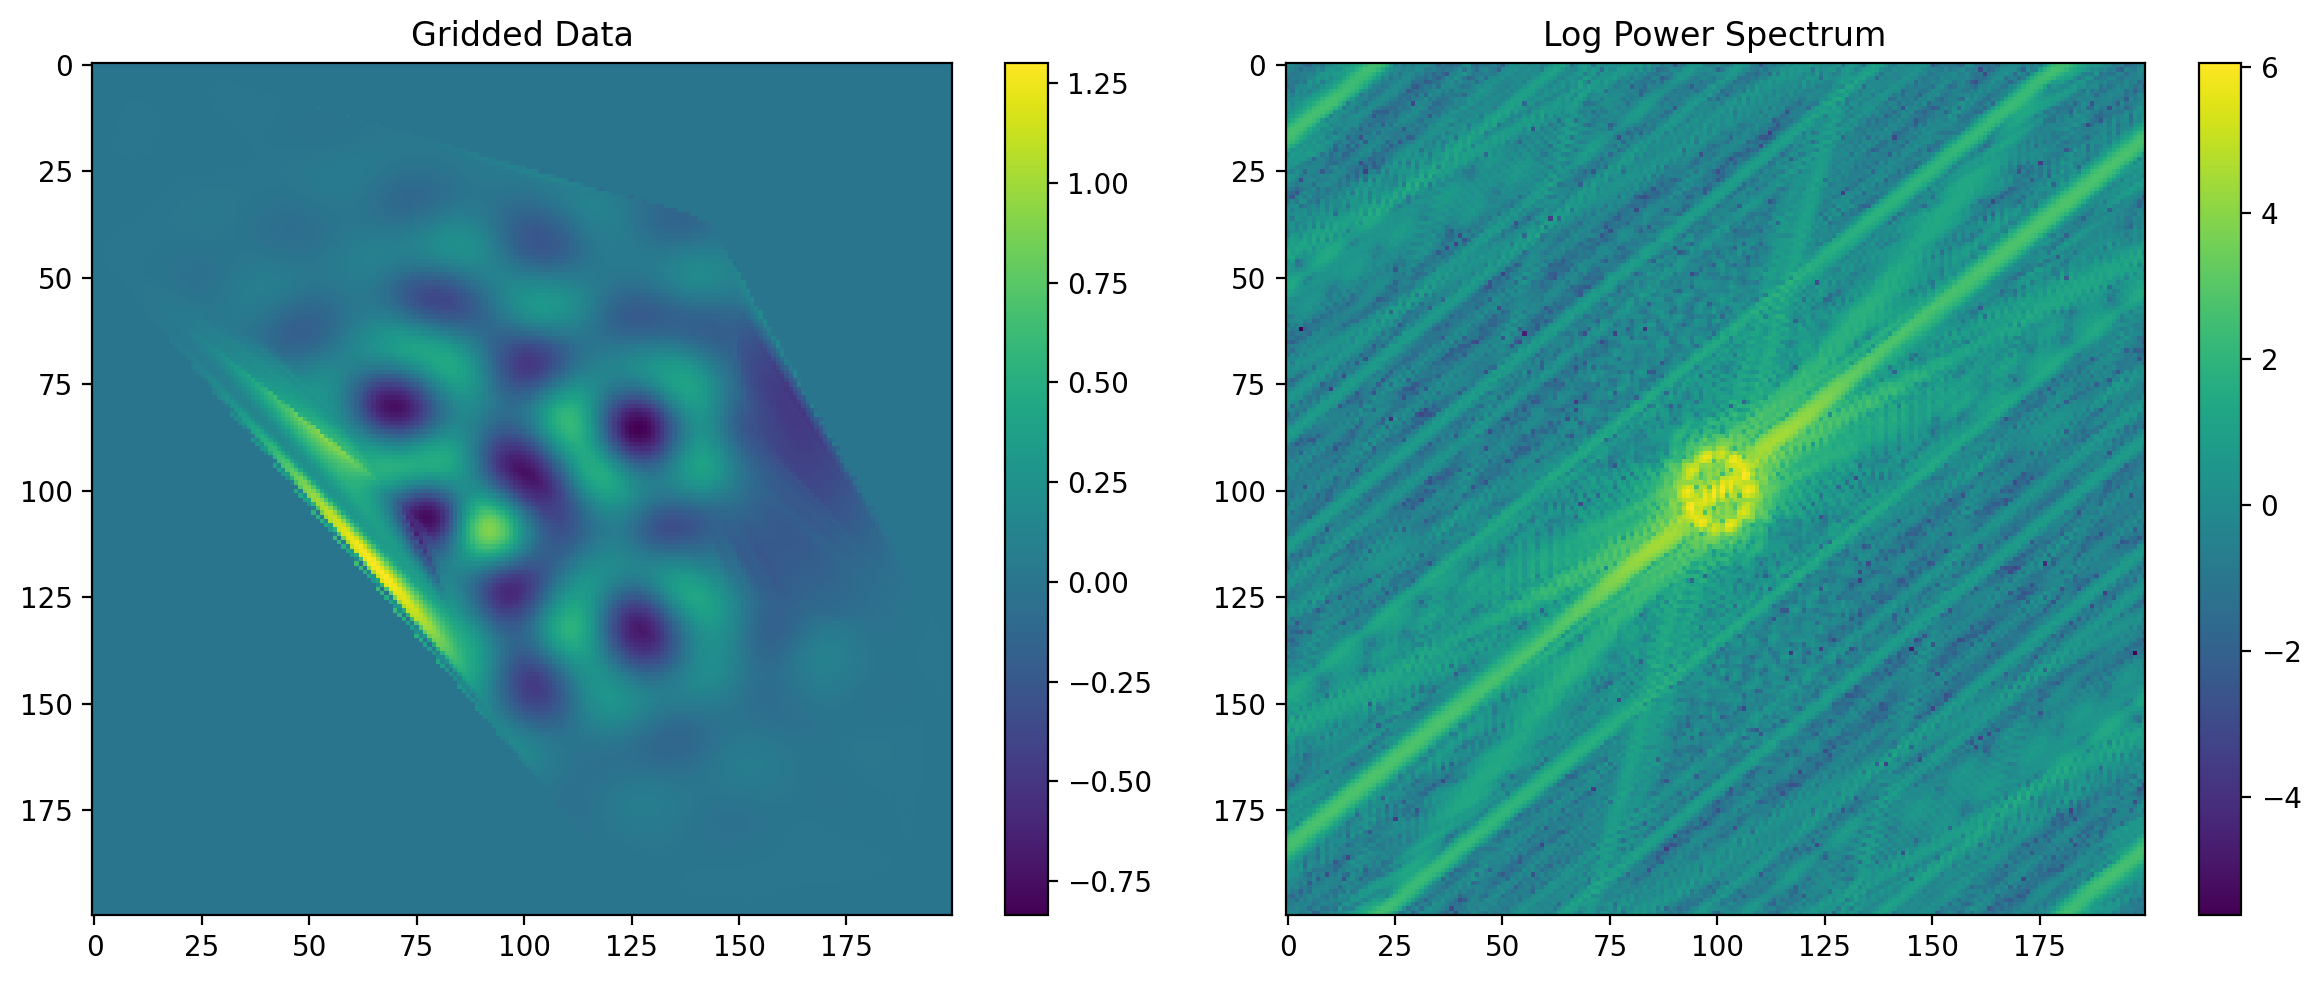

In [2]:
def get_length_scale(x, y, scalars):
    points = np.vstack((x, y))
    x_min = np.min(x)
    y_min = np.min(y)
    x_max = np.max(x)
    y_max = np.max(y)

    # Determine appropriate grid size based on data density
    avg_spacing_x = np.median(np.diff(np.sort(x)))
    avg_spacing_y = np.median(np.diff(np.sort(y)))
    nx = int((x_max - x_min) / avg_spacing_x)
    ny = int((y_max - y_min) / avg_spacing_y)

    # Ensure reasonable grid size
    nx = min(max(nx, 50), 200)
    ny = min(max(ny, 50), 200)

    grid_x, grid_y = np.mgrid[x_min : x_max : nx * 1j, y_min : y_max : ny * 1j]

    # Interpolate data
    grid_scalars = griddata(points.T, scalars, (grid_x, grid_y), method="cubic")

    # Instead of zero-padding, use mean value for NaNs
    mean_val = np.nanmean(grid_scalars)
    grid_scalars[np.isnan(grid_scalars)] = mean_val

    # Remove mean to focus on variations
    grid_scalars = grid_scalars - np.mean(grid_scalars)

    # Apply window function to reduce edge effects
    window = np.outer(np.hanning(ny), np.hanning(nx))
    grid_scalars = grid_scalars * window

    # Compute 2D FFT
    ft = fft2(grid_scalars)
    ft_shifted = fftshift(ft)
    power_spectrum = np.abs(ft_shifted) ** 2

    # Create frequency grids
    freq_x = np.fft.fftfreq(nx, d=(x_max - x_min) / nx)
    freq_y = np.fft.fftfreq(ny, d=(y_max - y_min) / ny)
    freq_x = np.fft.fftshift(freq_x)
    freq_y = np.fft.fftshift(freq_y)
    fx, fy = np.meshgrid(freq_x, freq_y)

    # Calculate radial frequencies
    freq_r = np.sqrt(fx**2 + fy**2)

    # Create mask for central region to avoid DC component
    center_mask = freq_r > (0.05 * np.max(freq_r))

    # Find peak in power spectrum avoiding central region
    masked_power = power_spectrum.copy()
    masked_power[~center_mask] = 0
    max_idx = np.unravel_index(np.argmax(masked_power), power_spectrum.shape)

    # Get corresponding frequency and convert to length scale
    dominant_frequency = freq_r[max_idx]
    if dominant_frequency > 0:
        characteristic_length_scale = 1.0 / dominant_frequency
    else:
        characteristic_length_scale = np.nan

    return characteristic_length_scale, grid_scalars, power_spectrum, freq_r


# Test with first mode
length_scale, grid_data, power_spec, freq_r = get_length_scale(x, y, modes[:, -1])
print(f"Length scale for first mode: {length_scale:.3f}")

# Visualize the data and its spectrum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
im1 = ax1.imshow(grid_data, aspect="auto")
plt.colorbar(im1, ax=ax1)
ax1.set_title("Gridded Data")

im2 = ax2.imshow(np.log10(power_spec), aspect="auto")
plt.colorbar(im2, ax=ax2)
ax2.set_title("Log Power Spectrum")
plt.tight_layout()
plt.show()

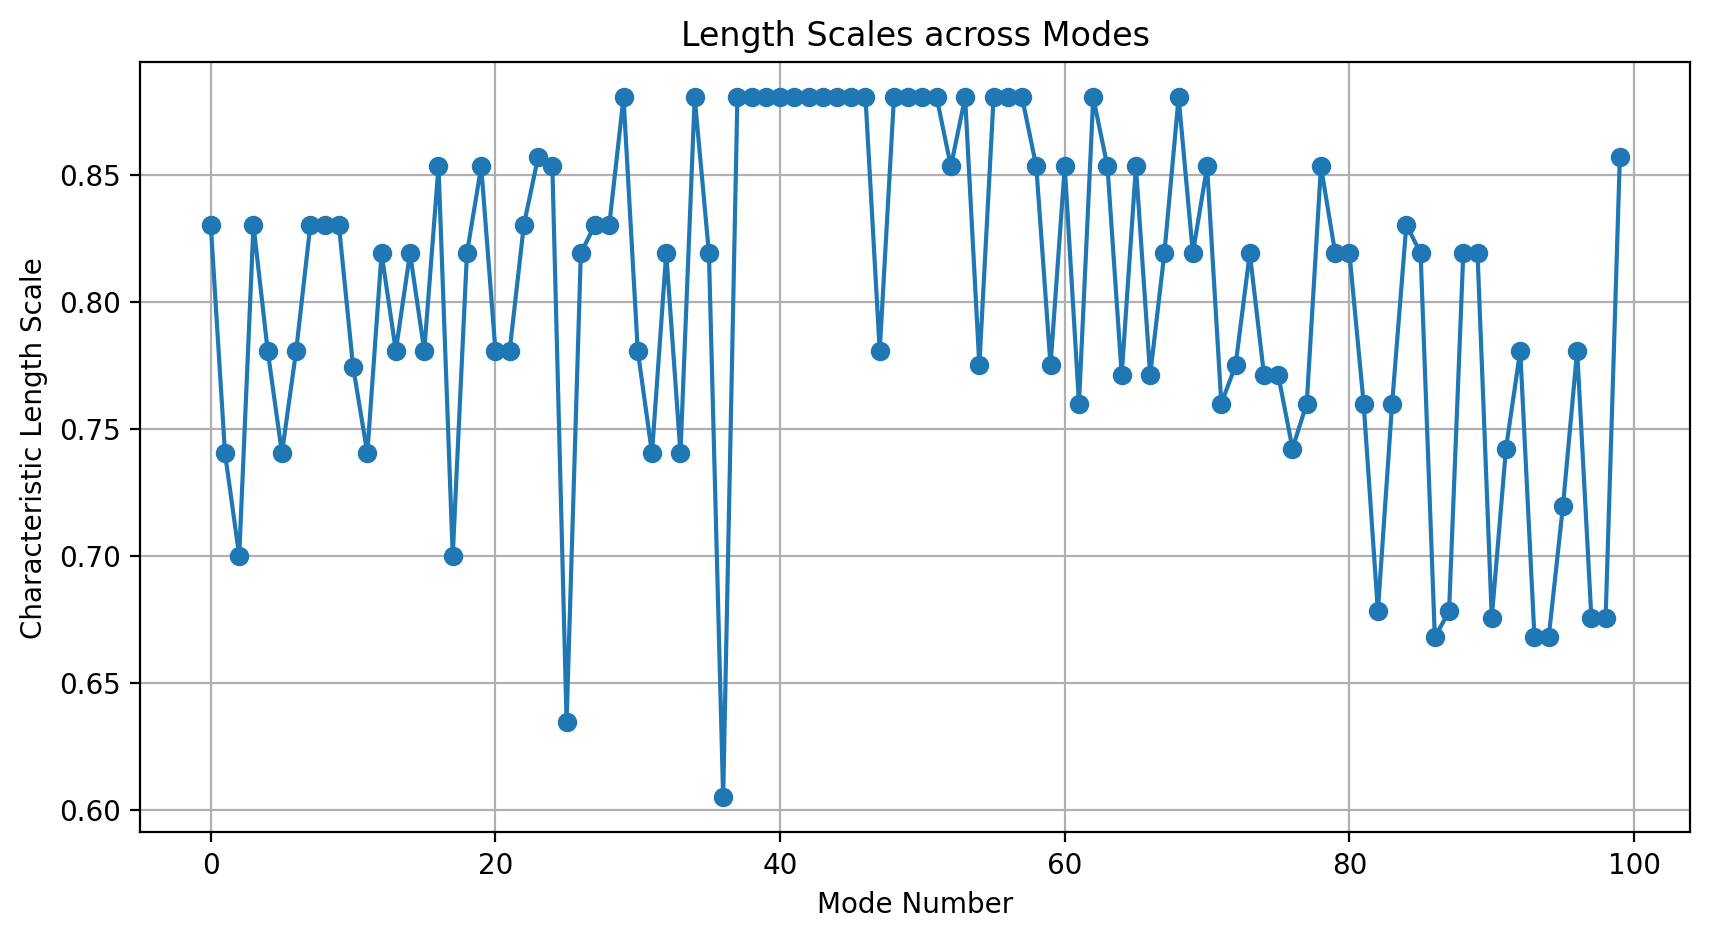

In [3]:
# Calculate length scales for all modes
length_vec = np.zeros(modes.shape[1])
for i in range(modes.shape[1]):
    length_vec[i], _, _, _ = get_length_scale(x, y, modes[:, i])

plt.figure(figsize=(10, 5))
plt.plot(length_vec, "-o")
plt.xlabel("Mode Number")
plt.ylabel("Characteristic Length Scale")
plt.title("Length Scales across Modes")
plt.grid(True)
plt.show()

# Normalize columns

In [4]:
from scipy.ndimage import gaussian_filter

# Create a regular grid
# grid_x, grid_y = np.mgrid[0:10:100j, 0:10:100j]

x_min = np.min(x)
y_min = np.min(y)
x_max = np.max(x)
y_max = np.max(y)

# Determine appropriate grid size based on data density
avg_spacing_x = np.median(np.diff(np.sort(x)))
avg_spacing_y = np.median(np.diff(np.sort(y)))
nx = int((x_max - x_min) / avg_spacing_x)
ny = int((y_max - y_min) / avg_spacing_y)

# Ensure reasonable grid size
nx = min(max(nx, 50), 200)
ny = min(max(ny, 50), 200)

grid_x, grid_y = np.mgrid[x_min : x_max : nx * 1j, y_min : y_max : ny * 1j]


# Interpolate the scalar field onto the grid
grid_s = griddata((x, y), modes[:, 10], (grid_x, grid_y), method="cubic")

mean_val = np.nanmean(grid_s)
grid_s[np.isnan(grid_s)] = mean_val


# Compute the gradient of the interpolated scalar field
grad_sx, grad_sy = np.gradient(grid_s)

# Compute the magnitude of the gradient
grad_s_magnitude = np.sqrt(grad_sx**2 + grad_sy**2)

# Smooth the gradient magnitude to reduce noise
grad_s_magnitude_smooth = gaussian_filter(grad_s_magnitude, sigma=1)

# Calculate the length scale as the inverse of the gradient magnitude
length_scale = 1 / (
    grad_s_magnitude_smooth + 1e-10
)  # Add small value to avoid division by zero

print(length_scale)

# Plot the length scale
# plt.figure(figsize=(10, 5))
# plt.imshow(length_scale, extent=(0, 10, 0, 10), origin="lower", cmap="viridis")
# plt.colorbar(label="Length Scale")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.title("Length Scale of Scalar Field")
# plt.show()

[[1.e+10 1.e+10 1.e+10 ... 1.e+10 1.e+10 1.e+10]
 [1.e+10 1.e+10 1.e+10 ... 1.e+10 1.e+10 1.e+10]
 [1.e+10 1.e+10 1.e+10 ... 1.e+10 1.e+10 1.e+10]
 ...
 [1.e+10 1.e+10 1.e+10 ... 1.e+10 1.e+10 1.e+10]
 [1.e+10 1.e+10 1.e+10 ... 1.e+10 1.e+10 1.e+10]
 [1.e+10 1.e+10 1.e+10 ... 1.e+10 1.e+10 1.e+10]]


(array([2.5084e+04, 6.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4904e+04]),
 array([1.1730969e+00, 1.0000000e+09, 2.0000000e+09, 3.0000000e+09,
        4.0000000e+09, 5.0000000e+09, 6.0000000e+09, 7.0000000e+09,
        8.0000000e+09, 9.0000000e+09, 1.0000000e+10]),
 <BarContainer object of 10 artists>)

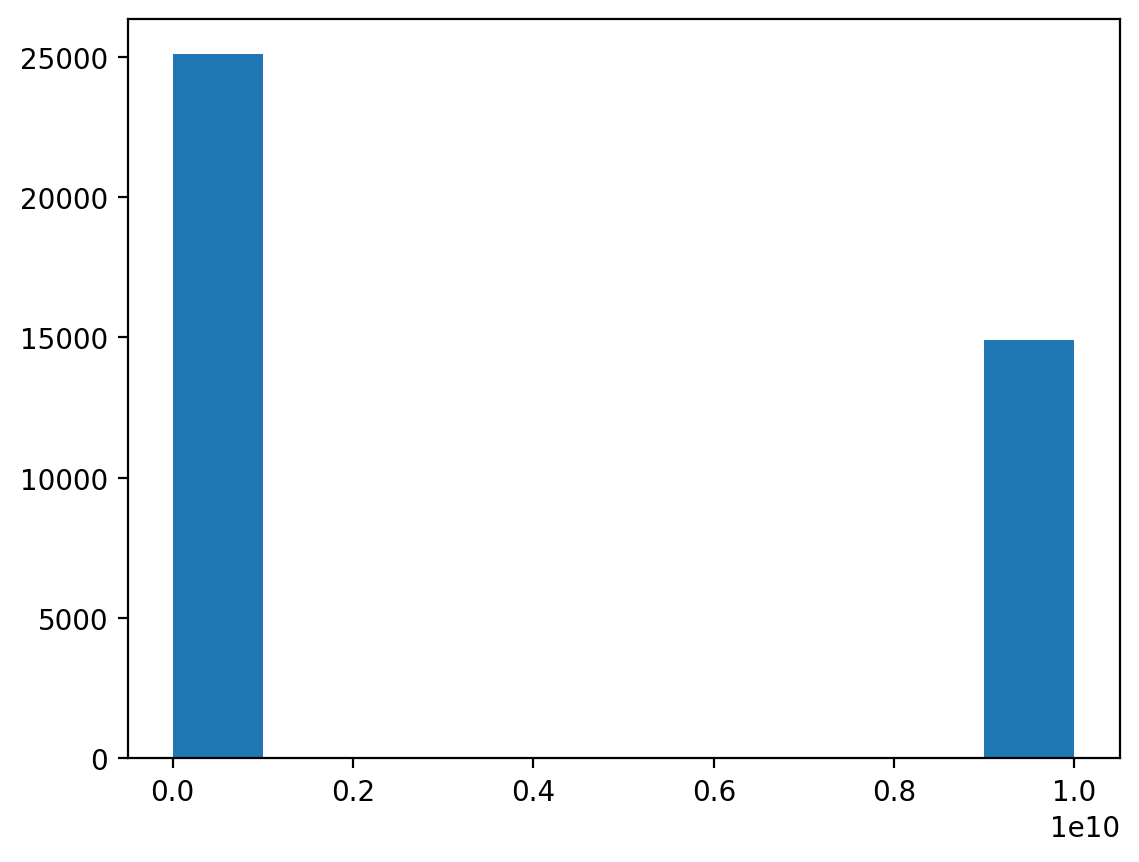

In [5]:
l = np.copy(length_scale)
plt.hist(length_scale.flatten())

51.93592005970791


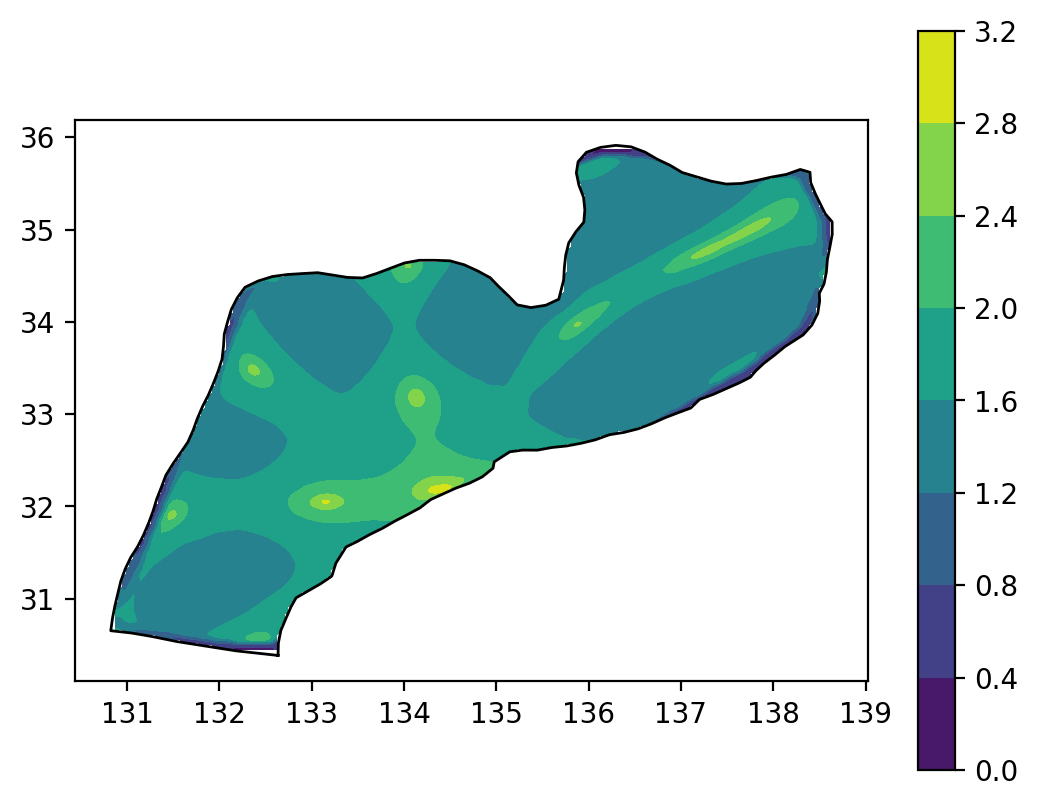

In [6]:
from matplotlib import path


def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


inpolygon_idx = inpolygon(grid_x.flatten(), grid_y.flatten(), x_edge, y_edge)
inpolygon_idx = inpolygon_idx.reshape(200, 200)

length_scale[~inpolygon_idx] = np.nan

print(np.nanmean(length_scale))

plt.contourf(grid_x, grid_y, np.log10(np.abs(length_scale)), cmap="viridis")
plt.colorbar()

plt.plot(x_edge, y_edge, color="black", linewidth=1)
plt.gca().set_aspect("equal")
plt.show()

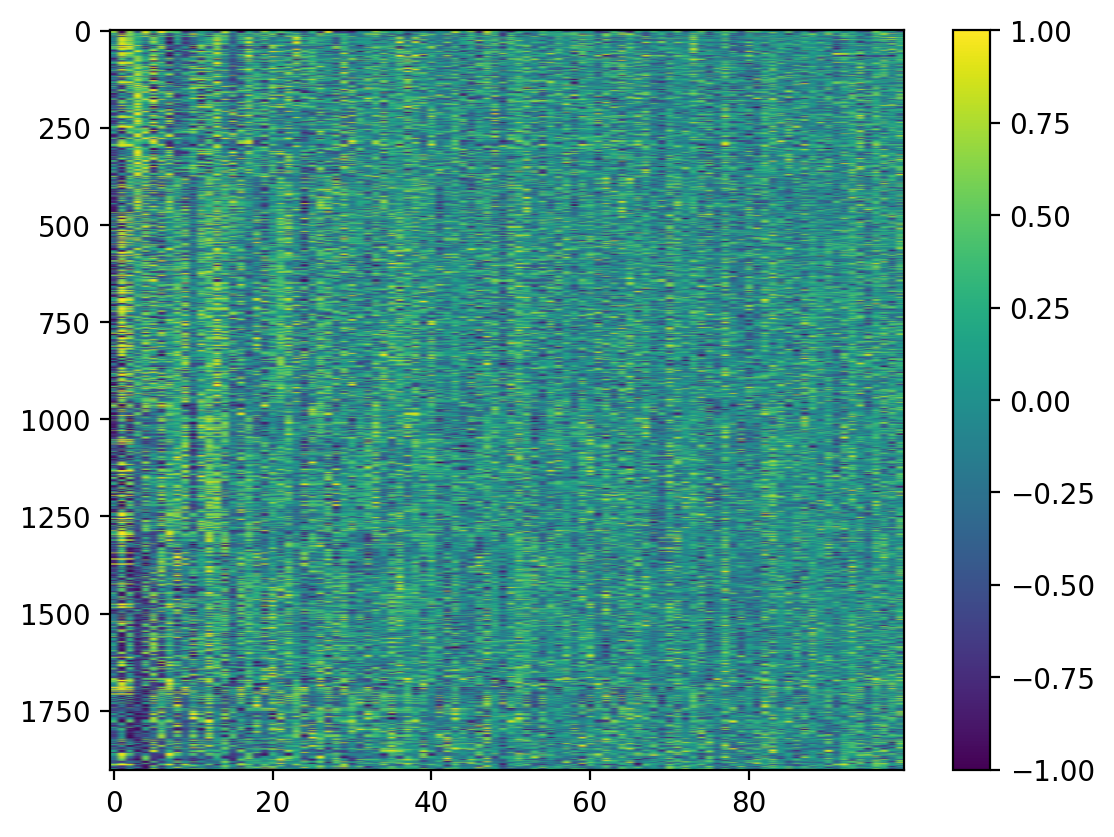

In [7]:
plt.imshow(modes, aspect="auto")
plt.colorbar()
plt.show()

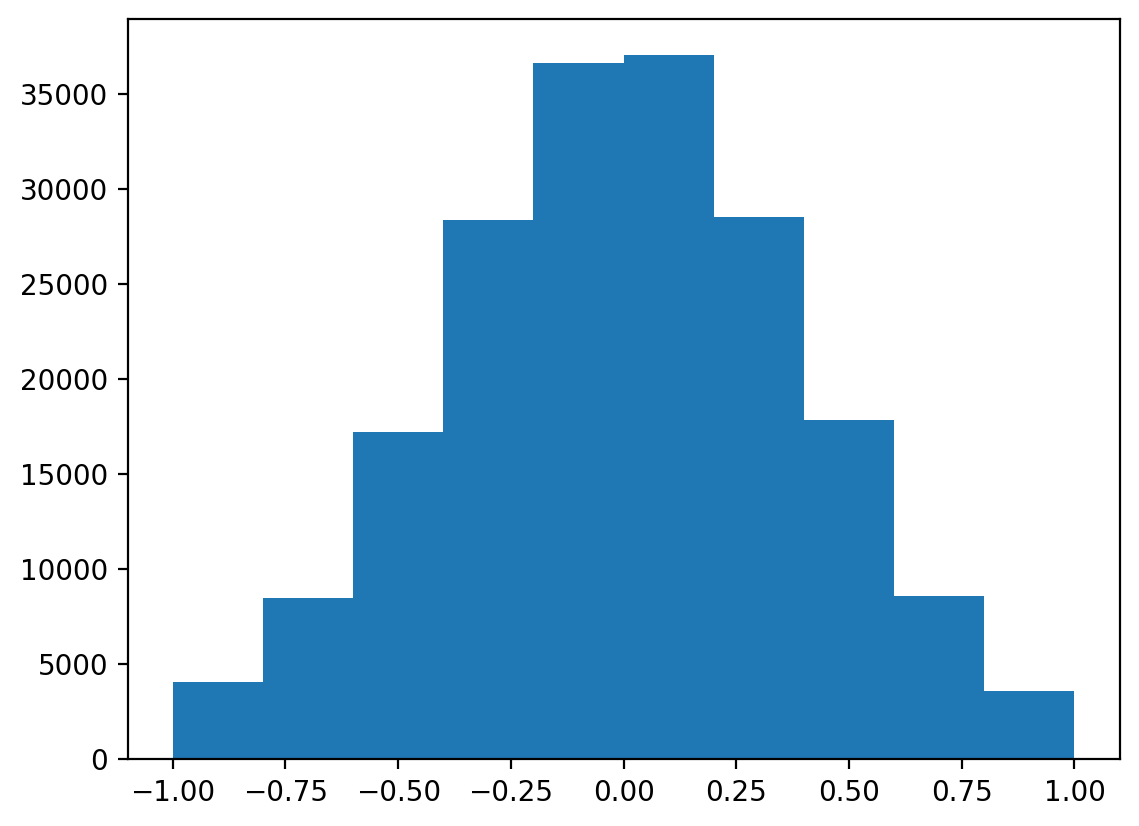

NameError: name 'A' is not defined

In [ ]:
plt.hist(modes.flatten())
plt.show()